# Motor Vehicle Death Analysis
After the data cleaning process done in [DataPreparation.ipynb](./DataPreparation.ipynb), let's go ahead with the analysis! We have covered the first 2 steps of the process and are now starting with the Data Preparation (and more specifically the feature selection).

As a reminder, here is the CRISP-DM workflow:
![crispdm.png](./source/crispdm.png)
## 0. Imports

In [1]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (30,30)
%matplotlib inline

import numpy as np

import pandas as pd
pd.set_option('display.max_columns', None)
import scipy.stats as stats

import seaborn as sns
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from statsmodels.graphics.gofplots import qqplot

from statsmodels.stats.outliers_influence import variance_inflation_factor

from yellowbrick.regressor import ResidualsPlot

## 0.1 Importing `.csv`

In [2]:
df = pd.read_csv('df.csv')
df.set_index('FIPS');

# 1. Dataset exploration
## 1.1 Visual exploration

In [3]:
[i for i in df.columns]

['FIPS',
 'State',
 'County',
 'Years_of_Potential_Life_Lost_Rate',
 'YPLL_Rate_(Black)',
 'YPLL_Rate_(Hispanic)',
 'YPLL_Rate_(White)',
 'percent_Fair_or_Poor',
 'Physically_Unhealthy_Days',
 'Mentally_Unhealthy_Days',
 'percent_LBW',
 'percent_LBW_(Black)',
 'percent_LBW_(Hispanic)',
 'percent_LBW_(White)',
 'percent_Smokers',
 'percent_Obese',
 'Food_Environment_Index',
 'percent_Physically_Inactive',
 'percent_With_Access',
 'percent_Excessive_Drinking',
 'percent_Alcohol_Impaired',
 'Chlamydia_Rate',
 'Teen_Birth_Rate',
 'Teen_Birth_Rate_(Black)',
 'Teen_Birth_Rate_(Hispanic)',
 'Teen_Birth_Rate_(White)',
 'percent_Uninsured_x',
 'PCP_Rate',
 'PCP_Ratio',
 'Dentist_Rate',
 'Dentist_Ratio',
 'MHP_Rate',
 'MHP_Ratio',
 'Preventable_Hosp_Rate',
 'Preventable_Hosp_Rate_(Black)',
 'Preventable_Hosp_Rate_(Hispanic)',
 'Preventable_Hosp_Rate_(White)',
 'percent_Screened',
 'percent_Screened_(Black)',
 'percent_Screened_(Hispanic)',
 'percent_Screened_(White)',
 'percent_Vaccinated',
 'pe

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


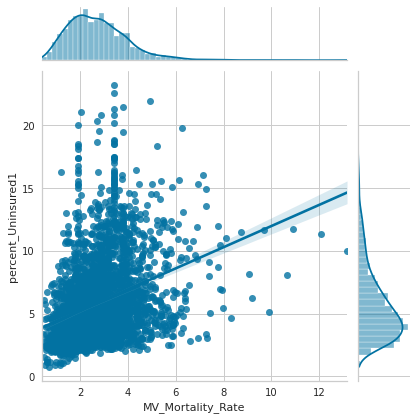

In [4]:
sns.jointplot('MV_Mortality_Rate','percent_Uninsured1', data=df, kind='reg');

## 1.2 Feature selection

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


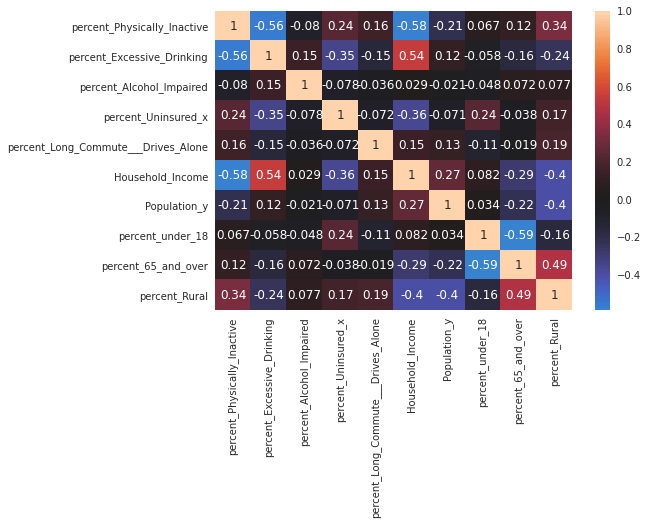

In [5]:
# Original feature list, narrowed down based on vif
# features = ['MV_Mortality_Rate',
#             'Years_of_Potential_Life_Lost_Rate',
#             'percent_Physically_Inactive',
#             'percent_Excessive_Drinking',
#             'percent_Alcohol_Impaired',
#             'percent_Uninsured_x',
#             'Average_Daily_PM25',
#             'percent_Drive_Alone',
#             'percent_Long_Commute___Drives_Alone',
#             'percent_Insufficient_Sleep',
#             'Household_Income',
#             'Population_y',
#             'percent_under_18',
#             'percent_65_and_over',
#             'percent_African_American',
#             'percent_American_Indian_or_Alaskan_Native',
#             'percent_Asian',
#             'percent_Native_Hawaiian_or_Other_Pacific_Islander',
#             'percent_Hispanic',
#             'percent_Non_Hispanic_White',
#             'percent_Not_Proficient_in_English',
#             'percent_Female',
#             'percent_Rural'
#         ]


features = ['MV_Mortality_Rate',
            'percent_Physically_Inactive',
            'percent_Excessive_Drinking',
            'percent_Alcohol_Impaired',
            'percent_Uninsured_x',
            'percent_Long_Commute___Drives_Alone',
            'Household_Income',
            'Population_y',
            'percent_under_18',
            'percent_65_and_over',
            'percent_Rural'
           ]

target = df['MV_Mortality_Rate']
dfFeatures = df[features].drop(columns='MV_Mortality_Rate')
sns.heatmap(dfFeatures.corr(), center=0, annot=True);

Using the Variance Inflator Factor, we can evaluate the multicollinearity between variables. The higher the VIF, the more the variables depend on each other. This is not something we want and our variables need to be as independant as possible. Thanks to the VIF analysis, we are able to remove the biggest multicollinearity issues.

In [6]:
vif = [variance_inflation_factor(dfFeatures.values, i) for i in range(dfFeatures.shape[1])]
list(zip(dfFeatures.columns, vif))

[('percent_Physically_Inactive', 35.54570813157014),
 ('percent_Excessive_Drinking', 38.79668742722354),
 ('percent_Alcohol_Impaired', 4.91961887492608),
 ('percent_Uninsured_x', 7.610705649820923),
 ('percent_Long_Commute___Drives_Alone', 9.816175466985127),
 ('Household_Income', 32.952387713752),
 ('Population_y', 1.388116715309433),
 ('percent_under_18', 49.8298787087958),
 ('percent_65_and_over', 22.463061937688472),
 ('percent_Rural', 8.287009034616409)]

# 2. Modeling

In [7]:
# Train/Test split (25%)
X_train, X_test, y_train, y_test = train_test_split(dfFeatures,
                                                    target,
                                                    test_size=0.25,
                                                    random_state=100
                                                   )
# Initialising K-Folds
kfold = KFold(n_splits=5, random_state=100, shuffle=True)

In [8]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

2356 786 2356 786


## 2.1 Linear regression model generation

In [9]:
# Scaling
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# model type
linmodel = LinearRegression()

# modelling itself
linmodel.fit(X_train_s,y_train)

LinearRegression()

## 2.2 Evaluating the baseline model

In [10]:
crossval = cross_validate(linmodel,
                          X_train_s,
                          y_train,
                          scoring=('r2', 'neg_mean_squared_error'),
                          cv=kfold,
                          return_train_score=True
                         )
for key, value in crossval.items():
    print(key, np.mean(value))

fit_time 0.0021323204040527345
score_time 0.001082134246826172
test_r2 0.49598654710149004
train_r2 0.5023338274598208
test_neg_mean_squared_error -0.832178242605497
train_neg_mean_squared_error -0.8201031407874669


As we can see above, our Rsquared value is just above 0.5 for our train dataset and just below 0.5 for our test dataset. This means the model fits the training dataset slighlty better than the test one, as one would expect.

_Note that as we are using a Kfold method, the test dataset is a portion of the training dataset and each portion - or fold - is used sequentially as the test dataset. The 0.49 value is an average of those iterations._

In [11]:
# The coefficients (standardised)
for i, column in enumerate(X_train.columns):
    print(f"The coefficient for {column} is {round(linmodel.coef_[i],3)}")
print('----------------------')
# The intercept
print(f'The intercept is {linmodel.intercept_}')

The coefficient for percent_Physically_Inactive is 0.182
The coefficient for percent_Excessive_Drinking is -0.045
The coefficient for percent_Alcohol_Impaired is 0.048
The coefficient for percent_Uninsured_x is 0.211
The coefficient for percent_Long_Commute___Drives_Alone is 0.053
The coefficient for Household_Income is -0.219
The coefficient for Population_y is -0.046
The coefficient for percent_under_18 is 0.297
The coefficient for percent_65_and_over is 0.112
The coefficient for percent_Rural is 0.484
----------------------
The intercept is 2.723747214690111


These coefficient seem to indicate the most influent factor is how rural a county is, followed by how young its driver population is, how many uninsured drivers are around and finally how inactive the population is.

In terms of negative correlation, the household income is pretty strong. Meaning less chance of a fatal crash for higher income households.

In [12]:
# MSE and R_squared
# y_hat_train = linmodel.predict(X_train_s)
# train_mse = mean_squared_error(y_train, y_hat_train)
# print(f'Train Mean Squarred Error: {train_mse}')
# print(f'Train Rsquared:{r2_score(y_train, y_hat_train)}')

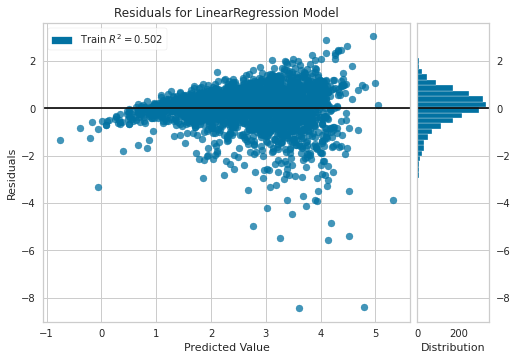

In [13]:
visualizer = ResidualsPlot(linmodel)
visualizer.fit(X_train_s, y_train)
# visualizer.score(X_test_train_s, y_test)
visualizer.show();

Analysing the residuals tells us our dataset is **bias** (this is probably due to the multicollinearities observed earlier in the analysis) and it is **heteroscedastic**; higher predicted values have more variance. This might be explained by the wide range of counties we are dealing with. All with different road policies, road infrastructures, funding, politics, etc.

## 2.3 Overfitting the model
The aim of this project is to practice penalisation techniques. To that end, we need to make sure our model overfits te training data.

We are going to polynomise our train dataset in order to maximise the Rsquared value (the goodness of fit indicator). We've tried all integers up to 5 (Rsquared = 1) but a cubic transformation brings a 0.64 Rsquare value which is more than enough considering the feature expansion trade-off. (considering our 10 variables, a third degree polynomial means we have about 286 features and interactions to analyse, a fourth degree brings us to 1001!)

In [14]:
# Polynomial transformation
poly_reg = PolynomialFeatures(degree=3)
X_poly = poly_reg.fit_transform(X_train)

# Standardisation
X_poly_s = scaler.fit_transform(X_poly)

# Modellisation
model = LinearRegression()
lin_reg_1 = model.fit(X_poly_s,y_train)

# Evaluation
y_pred = lin_reg_1.predict(X_poly_s)
print(f'Rsquared: {r2_score(y_train,lin_reg_1.predict(X_poly_s))}')

Rsquared: 0.6411292451761761


In [15]:
X_poly_s.shape

(2356, 286)

### 2.4 Penalisation, reducing the fit: LASSO, Ridge and Elastic net regressions
#### Hyperparameter tuning
We are going to use GridSearchCV in order to automatise the search of the best alpha value to use. The `np.linspace()` parameters were manually changed depending on the results returned. We would narrow the parameters down closer to the result returned so on the next pass, alpha would be more accurate.

Cells have been commented out because they take a reasonable amount of time to compute.

In [16]:
# ridge = Ridge()
# # alpha was narrowed down manually
# ridge_params = {'alpha' : np.linspace(503,505)}

# grid = GridSearchCV(estimator = ridge, 
#                     param_grid = ridge_params, 
#                     scoring = 'r2',
#                     cv = kfold,
#                     n_jobs = -1,
#                     return_train_score=True
#                    )

# grid = grid.fit(X_poly_s, y_train)
# alpha = grid.best_params_['alpha']
# print(f'alpha: {round(alpha,5)}')
# print(f'Rsquared: {round(grid.best_score_,5)}')

## alpha: 503.81633
## Rsquared: 0.52342

# pd.DataFrame(grid.cv_results_) give the detail of the cross validation results for all the alpha values

In [17]:
# lasso = Lasso()
# # alpha was narrowed down manually
# lasso_params = {'alpha' : np.linspace(.004, .005)}

# grid = GridSearchCV(estimator = lasso, 
#                     param_grid = lasso_params, 
#                     scoring = 'r2',
#                     cv = kfold,
#                     n_jobs = -1)

# grid = grid.fit(X_poly_s, y_train)
# alpha = grid.best_params_['alpha']
# print(f'alpha: {round(alpha,5)}')
# print(f'Rsquared: {round(grid.best_score_,5)}')

## alpha: 0.00469
## Rsquared: 0.52799

In [18]:
# enet = ElasticNet()
# # alpha was narrowed down manually
# elastic_params = {'alpha' : np.linspace(0, .5)}

# grid = GridSearchCV(estimator = enet, 
#                     param_grid = elastic_params, 
#                     scoring = 'r2',
#                     cv = kfold,
#                     n_jobs = -1)

# grid = grid.fit(X_poly_s, y_train)
# alpha = grid.best_params_['alpha']
# print(f'alpha: {round(alpha,5)}')
# print(f'Rsquared: {round(grid.best_score_,5)}')

## alpha: 0.0102
## Rsquared: 0.52825

## 2.5 Model selection

Based on Rsquared values, the ElasticNet (0.52825) performes better than the Lasso (0.52799) which performs better than the Ridge model (0.52342). However, considering our polynomial is cubic, we are going to select the Lasso model as it has the adantage to remove most of the features generated during the polynomisation step. This will hopefully allow the model to be more interpretable.

Here is a summary of the coefficients, for informational purposes only.

In [19]:
ridge = Ridge(alpha=503.81633)
ridge.fit(X_poly_s, y_train)

lasso = Lasso(alpha=0.00469)
lasso.fit(X_poly_s, y_train)

enet = ElasticNet(alpha=0.0102)
enet.fit(X_poly_s, y_train)

# The following coefficients are transformed and scaled
# (as they work on the _poly_ data)
print('LinearRegression parameter coefficients:', linmodel.coef_)
print('----------------------')
print('Ridge parameter coefficients:', ridge.coef_)
print('----------------------')
print('Lasso parameter coefficients:', lasso.coef_)
print('----------------------')
print('Elastic net parameter coefficients:', enet.coef_)

LinearRegression parameter coefficients: [ 0.1823552  -0.04498776  0.04752823  0.21080244  0.0525807  -0.21915116
 -0.04575683  0.29697762  0.11152051  0.48421046]
----------------------
Ridge parameter coefficients: [ 0.00000000e+00  2.99888164e-02 -3.78678249e-02  4.29079045e-03
  1.44632403e-02  1.16886103e-02 -3.69217120e-02 -1.05979962e-02
  9.41032261e-03  3.12682647e-02  4.73729125e-02  3.36285298e-02
 -3.04307110e-02  6.58773444e-03  1.71229590e-02  1.52727066e-02
 -2.73897631e-02 -1.32182963e-02  3.54393005e-02  1.63381051e-02
  4.42485755e-02 -1.41328256e-02  2.87393234e-03  2.48753548e-02
 -1.25531470e-02 -6.86281002e-03 -7.28292078e-03 -9.70828120e-03
 -1.26651757e-03  1.37981062e-02 -1.13608104e-02  7.98458327e-03
  1.34233833e-02 -1.33447338e-02  2.36350017e-04  1.11424538e-02
  2.14865465e-03  2.05311432e-02 -1.67171460e-02  2.07048792e-02
 -8.47628347e-03 -9.87214948e-03  1.79066221e-02  2.52194484e-02
  1.04178134e-02  4.62918656e-03 -1.75632507e-02  4.67701696e-03
  1

# 3. Testing the model

Training score: 0.5604116754987077
Testing score: 0.5643265991025365


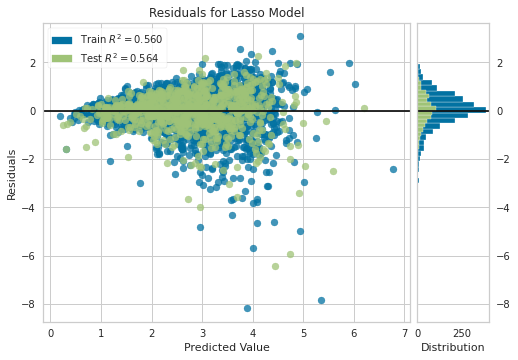

In [20]:
poly_reg = PolynomialFeatures(degree=3)
X_poly = poly_reg.fit_transform(X_train)
X_poly_s = scaler.transform(X_poly)

X_test_poly = poly_reg.transform(X_test)
X_test_poly_s = scaler.transform(X_test_poly)

lasso = Lasso(alpha=0.00469)
lasso.fit(X_poly_s, y_train)
print(f'Training score: {lasso.score(X_poly_s,y_train)}')
print(f'Testing score: {lasso.score(X_test_poly_s,y_test)}')
visualizer = ResidualsPlot(lasso)
visualizer.fit(X_poly_s, y_train)
visualizer.score(X_test_poly_s, y_test)
visualizer.show();

As shown above, the test residuals 'match' the train residuals; the scores are comparable. This tells us the model is robust. The scores are relatively low (56%) but it is better than the 50% we had in our baseline model.

The residuals graph shows there is a bias in the data, and there is some heteroscedasticity. We think by doing a better job at selecting our features this could be optimised.

The number of features, as well as the features themselves, used in this model were selected on an intuitive basis. We did this in order to improve the interpretability of the model, as opposed to select more variables or more complex interactions in order to get a more accurate model.

# 4. Weight of the variables/interactions

In this section we are going to descale and defactorise our coefficients so we will be able to see in which extent the affect the MVD.
As we can see in the `Value` column, the most obvious factors (and their combination is:
<details open>
    <summary>List of clearly identifyable factors</summary>
    <ul>Household income</ul>
    <ul>Uninsured</ul>
    <ul>Population</ul>
    <ul>Rurality level</ul>
    <ul>Under 18</ul>
</details>

As seen in [chapter 2.2](#2.2-Evaluating-the-baseline-model), the househod income and population have a negative correlation with the MVD.

In [21]:
coefname = poly_reg.get_feature_names(X_train.columns)
coefvalue = lasso.coef_
interactions = pd.DataFrame(list(zip(coefname,coefvalue)))
interactions.columns = ['Coefficient','ScaledValue']
interactions['PolyValue'] = scaler.inverse_transform(interactions['ScaledValue'])
interactions['Value'] = interactions['PolyValue']**(1./3)
interactions = interactions[interactions['ScaledValue']!=0]
interactions = interactions.sort_values(by='Value', ascending=False)
interactions

,Coefficient,ScaledValue,PolyValue,Value
251,Household_Income^3,0.020145,1.714546e+14,55554.130990
220,percent_Uninsured_x Population_y^2,0.002774,1.429536e+12,11265.012145
269,Population_y^2 percent_Rural,0.046407,4.584404e+11,7710.708717
259,Household_Income Population_y percent_Rural,-0.032197,1.022766e+11,4676.548584
151,percent_Excessive_Drinking Household_Income^2,0.173702,5.808431e+10,3872.751272
265,Household_Income percent_Rural^2,-0.012480,2.064207e+08,590.995837
275,Population_y percent_Rural^2,-0.144172,8.376832e+07,437.548904
244,percent_Long_Commute___Drives_Alone Population...,0.250721,8.281248e+07,435.878323
270,Population_y percent_under_18^2,-0.023822,5.019705e+07,368.886476
72,percent_Physically_Inactive^2 Population_y,-0.041091,4.788232e+07,363.126879


# 5. Closing the Loop
Not only our model is subject to bias and heteroscedasticity (as shown in the residual plot), its relatively inadequate performance does not allow to draw any conclusion. It does reinforce some intuition we have about this topic, but a more cautious feature selection/engineering would greatly benefit this analysis.

Given the large number of available features, a Principal Component Analysis could be a valid alternative to feature engineering. However, this project needs to result in some clear principles that can be implemented in real life to curb the motor vehicles mortality rate.

# 6. Principal Component Analysis
Correlating the interactions table with a principal component analysis should help us identify the main drivers for the mortality rate.

In [42]:
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

As this method is naive (unsupervised), we want to have a first-pass with as many variables as possible to try to identify factors contributing to the MVD. In the following cells, we will pre-process the data to have only numbers and no missing values. In terms of missing values, one of the most significant candidates is the breakdown of the number by race. We are going to remove those columns, as we assume race is not a primary driver of MVD. The missing values will then filled with the state median value. Some variables have a $NaN$ percentage above 50% (see the `nan` dictionary below for details). Any interpretation based on those indicators will have to be cautious.

In [23]:
df.drop(columns=[col for col in df.columns if '(Black' in col or '(Hispanic' in col or '(White' in col], inplace=True)

In [24]:
df.drop(columns=['PCP_Ratio', 'Dentist_Ratio', 'MHP_Ratio', 'Other_PCP_Ratio'], inplace=True)

In [25]:
df['Presence_of_violation'].replace({'Yes':1, 'No':0}, inplace=True)

In [26]:
nan= {}
for col in df.columns:
    if np.mean(df[col].isnull()) > 0:
        nan[col] = np.mean(df[col].isnull())*100
sorted(nan.items(), key=lambda x:x[1], reverse=True)

[('Infant_Mortality_Rate', 59.898154042011456),
 ('Homicide_Rate', 59.516231699554424),
 ('percent_Disconnected_Youth', 55.06047103755569),
 ('Drug_Overdose_Mortality_Rate', 45.2577975811585),
 ('Child_Mortality_Rate', 38.892425206874606),
 ('Segregation_index', 34.46849140674729),
 ('Firearm_Fatalities_Rate', 29.69446212603437),
 ('HIV_Prevalence_Rate', 22.851686823679184),
 ('Segregation_Index', 11.04392106938256),
 ('Cohort_Size', 9.484404837683003),
 ('MHP_Rate', 8.020369191597707),
 ('Annual_Average_Violent_Crimes', 6.07893061744112),
 ('Violent_Crime_Rate', 6.07893061744112),
 ('Chlamydia_Rate', 5.028644175684278),
 ('Teen_Birth_Rate', 4.583068109484405),
 ('PCP_Rate', 4.2966263526416295),
 ('percent_Free_or_Reduced_Lunch', 3.851050286441757),
 ('percent_LBW', 3.4054742202418846),
 ('Injury_Death_Rate', 3.278166772756206),
 ('Graduation_Rate', 3.1508593252705284),
 ('Dentist_Rate', 2.7052832590706557),
 ('Life_Expectancy', 2.196053469127944),
 ('Age_Adjusted_Mortality', 1.9414385

In [35]:
for col in nan:
    df[col].fillna(df.groupby(by='State')[col].transform('median'), inplace=True)

In [36]:
[f'{col} {np.mean(df[col].isnull())*100}' for col in df.columns if np.mean(df[col].isnull()) > 0]

['Cohort_Size 0.9229789942711649',
 'Presence_of_violation 0.15913430935709738',
 'HIV_Prevalence_Rate 2.100572883513686',
 'percent_Free_or_Reduced_Lunch 3.596435391470401']

In [37]:
df.drop(columns=['Cohort_Size', 'Presence_of_violation', 'HIV_Prevalence_Rate', 'percent_Free_or_Reduced_Lunch'], inplace=True)

In [38]:
X, y = df.drop(columns=['MV_Mortality_Rate', 'State', 'County']), df['MV_Mortality_Rate']

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [39]:
pca = PCA()
pca.fit(X_scaled)
X_pca = pca.fit_transform(X_scaled)

Running a PCA on all the indicators provided returns 77 components. The variance explained by the first three components is only up to 45.6%, and the 10 most significant components explain about 67.8% of the variance.

In [83]:
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_*100)

px.histogram(x=range(1, exp_var_cumul.shape[0] + 1),
             y=exp_var_cumul,
             labels={"x": "# Components", "y": "Explained Variance"},
             nbins=77
            )

In [62]:
[var*100 for var in pca.explained_variance_ratio_]

[25.96692725296645,
 11.657321311062299,
 7.962547178215542,
 5.10763026439658,
 3.692985931085184,
 3.422217393090025,
 3.3029612925848557,
 2.8243255447523214,
 2.1398491776102766,
 1.7850537886645177,
 1.6483222215932563,
 1.5698159769294409,
 1.5048336999928764,
 1.444708294962641,
 1.3819334735616073,
 1.2972746656259047,
 1.2581397074610932,
 1.1514751370770966,
 1.0327976039128393,
 0.9892476852799333,
 0.9457692306225078,
 0.9026399465757584,
 0.867323850828644,
 0.8376565938624023,
 0.8248262184874431,
 0.7639466448036176,
 0.7284163144707254,
 0.7074262844737431,
 0.6866562909655436,
 0.6424627965029845,
 0.6346349489912989,
 0.5928430615904009,
 0.5675515086788051,
 0.5460655362545492,
 0.5289785045277178,
 0.4964492154386941,
 0.48722198270134714,
 0.4694684071450821,
 0.4603443947483899,
 0.42060928356414057,
 0.40473745448946946,
 0.3900548952346328,
 0.36346184014611743,
 0.35074277854312064,
 0.33213284478643823,
 0.31476115550168027,
 0.3049050545973142,
 0.28310519980

In [81]:
labels = {str(i): f"PC {i+1} ({var:.1f}%)" for i, var in enumerate(pca.explained_variance_ratio_ * 100)}

px.scatter_matrix(X_scaled,
                  labels=labels,
                  dimensions=range(10),
                  color=df['MV_Mortality_Rate'],
                  width=1_500,
                  height=1_500
                 ).update_traces(diagonal_visible=False)